In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
from ipfx.feature_extractor import (SpikeFeatureExtractor, SpikeTrainFeatureExtractor)
import ipfx.stimulus_protocol_analysis as spa
from ipfx.epochs import get_stim_epoch
from ipfx.dataset.create import create_ephys_data_set
from ipfx.utilities import drop_failed_sweeps
from ipfx.data_set_features import extract_data_set_features
from ipfx.error import FeatureError

import matplotlib.pyplot as plt

In [3]:
def process_dataset_sweeps(data_set):
    drop_failed_sweeps(data_set)
    long_square_table = data_set.filtered_sweep_table(stimuli=data_set.ontology.long_square_names) 
    long_square_table = long_square_table[long_square_table['passed'] == True]
    long_square_table = long_square_table[long_square_table['clamp_mode'] == "CurrentClamp"]
    
    good_sweeps = list()
    for i in long_square_table.sweep_number:
        try:
            curr_sweep = data_set.sweep_set(i).sweeps[0]
            good_sweeps.append(i)
        except:
            print("Rejected " + str(i))

    long_square_table = long_square_table[long_square_table['sweep_number'].isin(good_sweeps)]
    long_square_sweeps = data_set.sweep_set(long_square_table.sweep_number)
    
    return long_square_sweeps


def extract_features(long_square_sweeps):
    # Select epoch corresponding to the actual recording from the sweeps
    # and align sweeps so that the experiment would start at the same time
    long_square_sweeps.select_epoch("recording")
    long_square_sweeps.align_to_start_of_epoch("experiment")   
    
    # find the start and end time of the stimulus
    # (treating the first sweep as representative)
    stim_start_index, stim_end_index = get_stim_epoch(long_square_sweeps.i[0])
    stim_start_time = long_square_sweeps.t[0][stim_start_index]
    stim_end_time = long_square_sweeps.t[0][stim_end_index]
    print(f'Start: {stim_start_time}, end: {stim_end_time}')
        
    spfx = SpikeFeatureExtractor(start=stim_start_time, end=stim_end_time, filter = 1)
    sptfx = SpikeTrainFeatureExtractor(start=stim_start_time, end=stim_end_time, baseline_interval = 0.05)

    # run the analysis and print out a few of the features
    lsa = spa.LongSquareAnalysis(spfx, sptfx, subthresh_min_amp=-100.0) #or should the subthresh min amp be -500?
    lsa_results = lsa.analyze(long_square_sweeps)
    
    return lsa_results


def plot_trace(nwb_path, save_path=None):
    data_set = create_ephys_data_set(nwb_file=nwb_path)
    sweeps = process_dataset_sweeps(data_set)
    lsa_features = extract_features(sweeps)
    
    #indexes to plot
    rheobase_sweep_index = lsa_features['rheobase_sweep'].name
    hero_sweep_index = lsa_features['hero_sweep'].name
    #most hyperpolarizing sweep index with most hyperpolarizing sweep injection
    most_hyp_sweep_index = lsa_features['sweeps'].sort_values(by = ['stim_amp']).iloc[0].name
    
    sweep_plot_index_list = [most_hyp_sweep_index, rheobase_sweep_index, hero_sweep_index]
    print(f'indexes to be plotted: {sweep_plot_index_list}')
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(8,8))

    for sweep_plot_index in sweep_plot_index_list:
        curr_sweep = sweeps.sweeps[sweep_plot_index]
        axes[0].plot(curr_sweep.t, curr_sweep.v)
        axes[1].plot(curr_sweep.t, curr_sweep.i)
        
    axes[0].set_xlim(0, 2)
    axes[1].set_xlim(0, 2)        

    axes[0].set_ylim(-100, 70)
    axes[1].set_ylim(-120, 200)
    
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, facecolor='w', dpi=300) 

In [4]:
output_path = Path('./output/figures/ephys_traces')
output_path.mkdir(exist_ok=True)

In [5]:
cell_1_id = '732048771'
cell_2_id = '732091715'

cell1_path = 'data/ephys/sub-731978186_ses-732048771_icephys.nwb'
cell2_path = 'data/ephys/sub-731978186_ses-732091715_icephys.nwb'

## Plotting most hyperpolarizing, rheobase and hero sweeps for the 2 cells

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/hdmf/spec/namespace.py:484: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999
indexes to be plotted: [0, 6, 8]


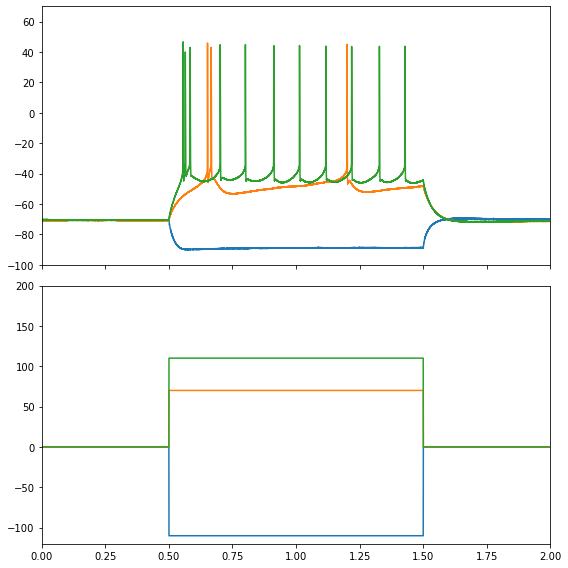

In [6]:
plot_trace(cell1_path)

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/hdmf/spec/namespace.py:484: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999
indexes to be plotted: [0, 7, 8]


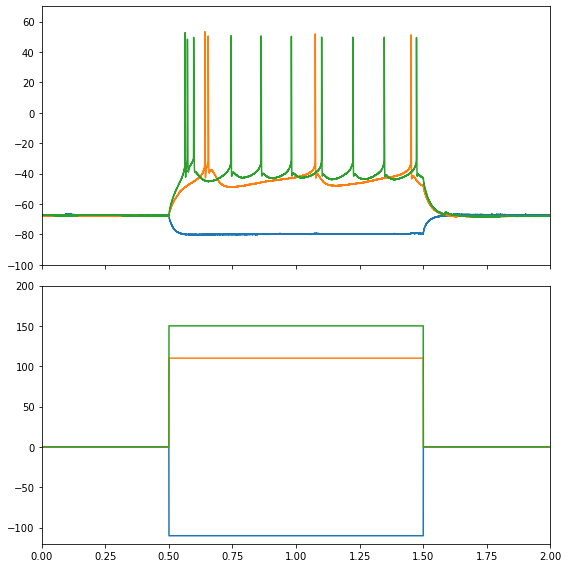

In [7]:
plot_trace(cell2_path)

## Plotting specific stimulation amplitudes that are shared between the 2 cells

In [8]:
data_set1 = create_ephys_data_set(nwb_file=cell1_path)
lsa_sweeps1 = process_dataset_sweeps(data_set1)
lsa_features1 = extract_features(lsa_sweeps1)

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/hdmf/spec/namespace.py:484: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999


In [10]:
lsa_features1['sweeps']

,avg_rate,peak_deflect,stim_amp,v_baseline,sag,adapt,latency,isi_cv,mean_isi,median_isi,first_isi
0,0.00000,"(-90.09376, 54226)",-110.000000,-70.739548,0.058830,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00000,"(-87.5625, 55258)",-90.000000,-70.778564,0.049550,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00000,"(-85.09375, 56432)",-70.000000,-70.765900,0.058506,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00000,"(-82.4375, 86425)",-50.000000,-70.266266,0.092299,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00000,"(-77.25, 59098)",-29.999998,-70.034210,0.095038,NaN,NaN,NaN,NaN,NaN,NaN
5,0.00000,"(-54.968754, 99201)",50.000000,-70.443787,-34.477310,NaN,NaN,NaN,NaN,NaN,NaN
6,3.00006,"(45.906254, 58596)",70.000000,-70.851135,-41.886105,0.947867,0.15082,0.947867,0.274300,0.27430,0.01430
7,0.00000,"(-50.062504, 64324)",59.999996,-71.006485,-42.091404,NaN,NaN,NaN,NaN,NaN,NaN
8,11.00022,"(46.687504, 53804)",110.000000,-70.669403,-31.617584,0.114936,0.05496,0.428314,0.087196,0.10131,0.00824
9,17.00034,"(46.718754, 52748)",150.000000,-70.523964,-28.940203,0.066055,0.03384,0.323481,0.058801,0.06621,0.00782


In [11]:
data_set2 = create_ephys_data_set(nwb_file=cell2_path)
lsa_sweeps2= process_dataset_sweeps(data_set2)
lsa_features2 = extract_features(lsa_sweeps2)

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/hdmf/spec/namespace.py:484: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Start: 0.5, end: 1.4999799999999999


In [12]:
lsa_features2['sweeps']

,avg_rate,peak_deflect,stim_amp,v_baseline,sag,adapt,latency,isi_cv,mean_isi,median_isi,first_isi
0,0.00000,"(-80.34375, 56326)",-110.000000,-67.490189,0.064268,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00000,"(-78.87501, 57910)",-90.000000,-67.491310,0.059331,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00000,"(-76.90626, 92698)",-70.000000,-68.070229,0.068583,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00000,"(-75.03125, 61921)",-50.000000,-68.301262,0.041631,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00000,"(-73.0625, 90998)",-29.999998,-68.612137,0.023101,NaN,NaN,NaN,NaN,NaN,NaN
5,0.00000,"(-46.718754, 64424)",100.000000,-67.346474,-31.154922,NaN,NaN,NaN,NaN,NaN,NaN
6,5.00010,"(52.187504, 57161)",119.999992,-67.768227,-32.932579,0.306323,0.12216,0.551054,0.206450,0.26638,0.01012
7,4.00008,"(53.375004, 58075)",110.000000,-67.854279,-34.436897,0.441988,0.14044,0.676155,0.270173,0.37652,0.01310
8,10.00020,"(52.71875, 54179)",150.000000,-67.669861,-35.156876,0.136716,0.06252,0.453764,0.101102,0.11914,0.00924
9,14.00028,"(51.812504, 53007)",190.000000,-67.495178,-14.937338,0.079005,0.03910,0.366001,0.068694,0.07734,0.00788


### The stim_amplitude values of -110, 110 and 150 are used in both cells, but have different indexes.

In [13]:
# Cell 1 indexes
most_hyp_sweep_index_c1 = lsa_features1['sweeps'].sort_values(by = ['stim_amp']).iloc[0].name
mid_sweep_index_c1 = lsa_features1['sweeps'][lsa_features1['sweeps'].stim_amp == 110].iloc[0].name
max_sweep_index_c1 = lsa_features1['sweeps'][lsa_features1['sweeps'].stim_amp == 150].iloc[0].name

sweep_plot_index_list_c1 = [most_hyp_sweep_index_c1, mid_sweep_index_c1, max_sweep_index_c1]

In [14]:
# Cell 2 indexes
most_hyp_sweep_index_c2 = lsa_features2['sweeps'].sort_values(by = ['stim_amp']).iloc[0].name
mid_sweep_index_c2 = lsa_features2['sweeps'][lsa_features2['sweeps'].stim_amp == 110].iloc[0].name
max_sweep_index_c2 = lsa_features2['sweeps'][lsa_features2['sweeps'].stim_amp == 150].iloc[0].name

sweep_plot_index_list_c2 = [most_hyp_sweep_index_c2, mid_sweep_index_c2, max_sweep_index_c2]

In [15]:
print(sweep_plot_index_list_c1)
print(sweep_plot_index_list_c2)

[0, 8, 9]
[0, 7, 8]


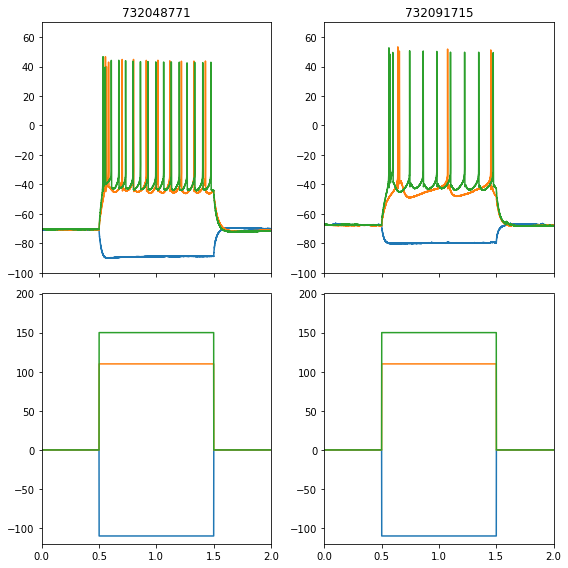

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(8,8))

for sweep_plot_index in sweep_plot_index_list_c1:
    curr_sweep = lsa_sweeps1.sweeps[sweep_plot_index]
    axes[0][0].plot(curr_sweep.t, curr_sweep.v)
    axes[1][0].plot(curr_sweep.t, curr_sweep.i)

for sweep_plot_index in sweep_plot_index_list_c2:
    curr_sweep = lsa_sweeps2.sweeps[sweep_plot_index]
    axes[0][1].plot(curr_sweep.t, curr_sweep.v)
    axes[1][1].plot(curr_sweep.t, curr_sweep.i)

axes[0][0].set_title(f'{cell_1_id}')
axes[0][1].set_title(f'{cell_2_id}')
    
axes[0][0].set_xlim(0, 2)
axes[1][0].set_xlim(0, 2)        

axes[0][0].set_ylim(-100, 70)
axes[0][1].set_ylim(-100, 70)
axes[1][0].set_ylim(-120, 200)
axes[1][1].set_ylim(-120, 200)

plt.tight_layout()
#fig.savefig(output_path/'trace_comparison.pdf', facecolor='w', dpi=300) 

## Remove borders

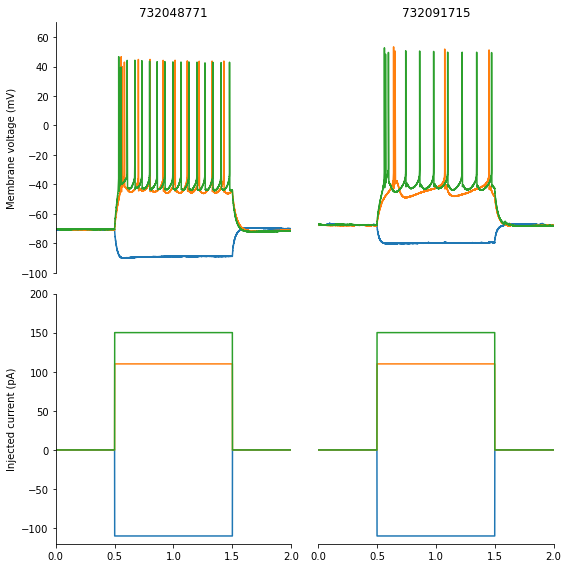

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(8,8))

for sweep_plot_index in sweep_plot_index_list_c1:
    curr_sweep = lsa_sweeps1.sweeps[sweep_plot_index]
    axes[0][0].plot(curr_sweep.t, curr_sweep.v)
    axes[1][0].plot(curr_sweep.t, curr_sweep.i)

for sweep_plot_index in sweep_plot_index_list_c2:
    curr_sweep = lsa_sweeps2.sweeps[sweep_plot_index]
    axes[0][1].plot(curr_sweep.t, curr_sweep.v)
    axes[1][1].plot(curr_sweep.t, curr_sweep.i)

axes[0][0].set_title(f'{cell_1_id}')
axes[0][1].set_title(f'{cell_2_id}')
    
axes[0][0].set_xlim(0, 2)
axes[0][1].set_xlim(0, 2)
axes[1][0].set_xlim(0, 2)    
axes[1][1].set_xlim(0, 2)        

axes[0][0].set_ylim(-100, 70)
axes[0][1].set_ylim(-100, 70)
axes[1][0].set_ylim(-120, 200)
axes[1][1].set_ylim(-120, 200)

axes[0][0].set_ylabel("Membrane voltage (mV)")
axes[1][0].set_ylabel("Injected current (pA)")

axes[0][0].spines['top'].set_visible(False)
axes[0][0].spines['right'].set_visible(False)
axes[0][0].spines['bottom'].set_visible(False)
axes[0][0].set_xticks([])
axes[0][1].axis('off')
axes[1][0].spines['top'].set_visible(False)
axes[1][0].spines['right'].set_visible(False)
axes[1][1].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)
axes[1][1].spines['left'].set_visible(False)
axes[1][1].set_yticks([])


plt.tight_layout()

## Plot v2
- Plot 3 separate subplots on a single row: include both cells on a single plot and below show the stimulation.
- Add a frequency/current plot to summarize

In [20]:
for ix1, ix2 in zip(sweep_plot_index_list_c1, sweep_plot_index_list_c2):
    print(ix1, ix2)

0 0
8 7
9 8


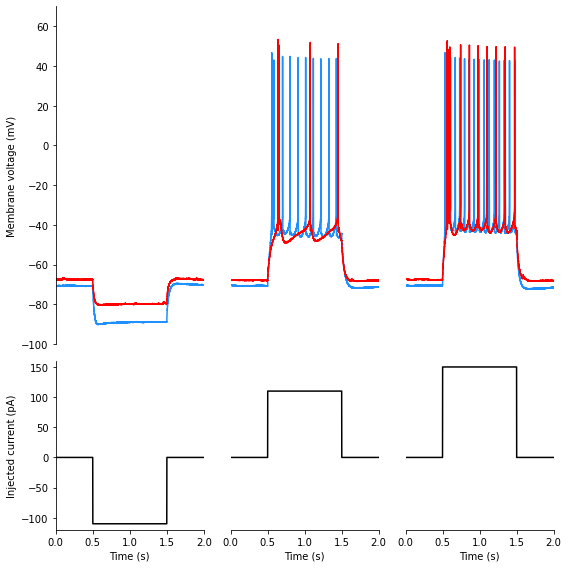

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=False, gridspec_kw={'height_ratios': [2, 1]}, figsize=(8,8))

for i, (sweep_ix1, sweep_ix2) in enumerate(zip(sweep_plot_index_list_c1, sweep_plot_index_list_c2)):
    cell_1_sweep = lsa_sweeps1.sweeps[sweep_ix1]
    cell_2_sweep = lsa_sweeps2.sweeps[sweep_ix2]
    axes[0][i].plot(cell_1_sweep.t, cell_1_sweep.v, color='dodgerblue')
    axes[0][i].plot(cell_2_sweep.t, cell_2_sweep.v, color='red')
    axes[1][i].plot(cell_1_sweep.t, cell_1_sweep.i, color='k')

#axes[0][0].set_title(f'{cell_1_id}')
#axes[0][1].set_title(f'{cell_2_id}')
        
axes[0][0].set_xlim(0, 2)
axes[0][1].set_xlim(0, 2)
axes[0][2].set_xlim(0, 2)
axes[1][0].set_xlim(0, 2)    
axes[1][1].set_xlim(0, 2)        
axes[1][2].set_xlim(0, 2)      

axes[0][0].set_ylim(-100, 70)
axes[0][1].set_ylim(-100, 70)
axes[0][2].set_ylim(-100, 70)
axes[1][0].set_ylim(-120, 160)
axes[1][1].set_ylim(-120, 160)
axes[1][2].set_ylim(-120, 160)

axes[0][0].set_ylabel("Membrane voltage (mV)")
axes[1][0].set_ylabel("Injected current (pA)")

axes[1][0].set_xlabel("Time (s)")
axes[1][1].set_xlabel("Time (s)")
axes[1][2].set_xlabel("Time (s)")

for ax in fig.get_axes():
    ax.label_outer()
    
axes[0][0].spines['top'].set_visible(False)
axes[0][0].spines['right'].set_visible(False)
axes[0][0].spines['bottom'].set_visible(False)
axes[0][0].set_xticks([])

axes[0][1].axis('off')
axes[0][2].axis('off')

axes[1][0].spines['top'].set_visible(False)
axes[1][0].spines['right'].set_visible(False)

axes[1][1].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)

axes[1][1].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)
axes[1][1].spines['left'].set_visible(False)
axes[1][1].set_yticks([])

axes[1][2].spines['top'].set_visible(False)
axes[1][2].spines['right'].set_visible(False)
axes[1][2].spines['left'].set_visible(False)
axes[1][2].set_yticks([])

plt.tight_layout()
fig.savefig(output_path/'trace_comparison_v2.svg', facecolor='w', dpi=300) 

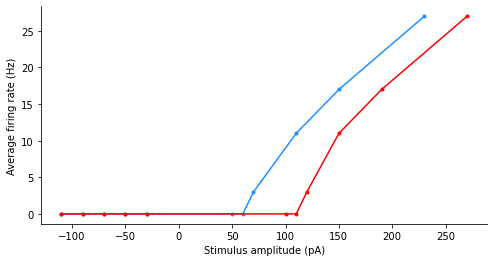

In [78]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(lsa_features1['sweeps'].sort_values('stim_amp')['stim_amp'], lsa_features1['sweeps'].sort_values('stim_amp')['avg_rate'], '.-', color='dodgerblue')
ax.plot(lsa_features2['sweeps'].sort_values('stim_amp')['stim_amp'], lsa_features1['sweeps'].sort_values('stim_amp')['avg_rate'], '.-', color='red')

ax.set_ylabel("Average firing rate (Hz)")
ax.set_xlabel("Stimulus amplitude (pA)")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(output_path/'fI_cell_comparison.svg', facecolor='w', dpi=300) 

## Include the f/I curve into the same figure as the traces
TODO

In [ ]:
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(2,3)
ax2 = plt.subplot(2,3)
ax3 = plt.subplot(2,3)
ax4 = plt.subplot(2,3,)
axes = [ax1, ax2, ax3, ax4]

In [60]:
import matplotlib.gridspec as gridspec

In [ ]:
fig = plt.figure(figsize=(8,8))
spec = fig.add_gridspec(3, 3)

ax00 = fig.add_subplot(spec[0, 0])
annotate_axes(ax00, 'ax00')

ax01 = fig.add_subplot(spec[0, 1])
annotate_axes(ax01, 'ax01')

ax02 = fig.add_subplot(spec[0, 2])
annotate_axes(ax02, 'ax02')

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

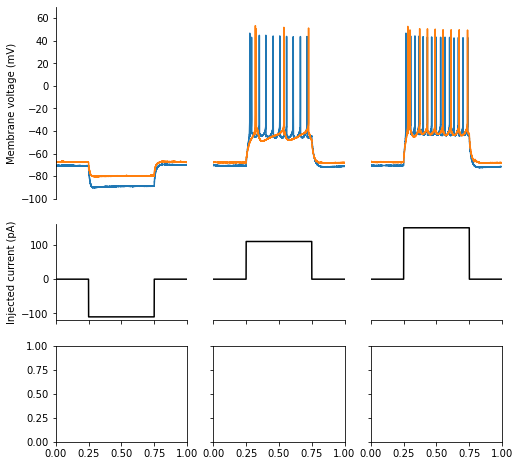

In [63]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=False, gridspec_kw={'height_ratios': [2, 1, 1]}, figsize=(8,8))


for i, (sweep_ix1, sweep_ix2) in enumerate(zip(sweep_plot_index_list_c1, sweep_plot_index_list_c2)):
    cell_1_sweep = lsa_sweeps1.sweeps[sweep_ix1]
    cell_2_sweep = lsa_sweeps2.sweeps[sweep_ix2]
    axes[0][i].plot(cell_1_sweep.t, cell_1_sweep.v)
    axes[0][i].plot(cell_2_sweep.t, cell_2_sweep.v)
    axes[1][i].plot(cell_1_sweep.t, cell_1_sweep.i, color='k')

#axes[0][0].set_title(f'{cell_1_id}')
#axes[0][1].set_title(f'{cell_2_id}')
        
axes[0][0].set_xlim(0, 2)
axes[0][1].set_xlim(0, 2)
axes[0][2].set_xlim(0, 2)
axes[1][0].set_xlim(0, 2)    
axes[1][1].set_xlim(0, 2)        
axes[1][2].set_xlim(0, 2)      

axes[0][0].set_ylim(-100, 70)
axes[0][1].set_ylim(-100, 70)
axes[0][2].set_ylim(-100, 70)
axes[1][0].set_ylim(-120, 160)
axes[1][1].set_ylim(-120, 160)
axes[1][2].set_ylim(-120, 160)

axes[0][0].set_ylabel("Membrane voltage (mV)")
axes[1][0].set_ylabel("Injected current (pA)")

axes[1][0].set_xlabel("Time (s)")
axes[1][1].set_xlabel("Time (s)")
axes[1][2].set_xlabel("Time (s)")

for ax in fig.get_axes():
    ax.label_outer()
    
axes[0][0].spines['top'].set_visible(False)
axes[0][0].spines['right'].set_visible(False)
axes[0][0].spines['bottom'].set_visible(False)
axes[0][0].set_xticks([])

axes[0][1].axis('off')
axes[0][2].axis('off')

axes[1][0].spines['top'].set_visible(False)
axes[1][0].spines['right'].set_visible(False)

axes[1][1].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)

axes[1][1].spines['top'].set_visible(False)
axes[1][1].spines['right'].set_visible(False)
axes[1][1].spines['left'].set_visible(False)
axes[1][1].set_yticks([])

axes[1][2].spines['top'].set_visible(False)
axes[1][2].spines['right'].set_visible(False)
axes[1][2].spines['left'].set_visible(False)
axes[1][2].set_yticks([])


plt.tight_layout()
#fig.savefig(output_path/'trace_comparison_v2.pdf', facecolor='w', dpi=300) 